In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.preprocessing import (
    OneHotEncoder,
    PolynomialFeatures,
    RobustScaler,
)


%matplotlib inline

In [27]:
class Loader:
    def __init__(self, data_dir):
        self.data_dir = data_dir
        self.pipeline = Pipeline(
            [
                ("imputer", SimpleImputer(strategy="mean")),
                ("features",FeatureUnion([
                    ("poly", PolynomialFeatures(
                        degree=2,
                        interaction_only=False,
                        include_bias=True,
                    ))
                ])),
                ("scaler", RobustScaler()),
            ]
        )
        self.poly_data = None
        self.weekly_index = None

    def transform_train_data(self, numeric_cols):
        df_train = pd.read_csv(self.data_dir / "train.csv")
        rows_sj = df_train["city"] == "sj"
        rows_iq = df_train["city"] == "iq"

        weekly_cases_sj = df_train[rows_sj][
            ["weekofyear", "total_cases"]
        ].groupby("weekofyear").mean()
        poly_fit_sj = np.polyfit(
            weekly_cases_sj.index,
            weekly_cases_sj["total_cases"],
            deg=4,
        )
        poly_line_sj = np.poly1d(poly_fit_sj)

        weekly_cases_iq = df_train[rows_iq][
            ["weekofyear", "total_cases"]
        ].groupby("weekofyear").mean()
        poly_fit_iq = np.polyfit(
            weekly_cases_iq.index,
            weekly_cases_iq["total_cases"],
            deg=4,
        )
        poly_line_iq = np.poly1d(poly_fit_iq)

        self.poly_data = dict(
            sj=poly_line_sj(weekly_cases_sj.index),
            iq=poly_line_iq(weekly_cases_iq.index),
        )
        self.weekly_index = weekly_cases_sj.index
        for i in self.weekly_index:
            df_train.loc[
                rows_sj & (df_train["weekofyear"] == i),
                "poly_fit",
            ] = self.poly_data["sj"][i - 1]
            df_train.loc[
                rows_iq & (df_train["weekofyear"] == i),
                "poly_fit",
            ] = self.poly_data["iq"][i - 1]
        df_train_sj = df_train[rows_sj]
        df_train_iq = df_train[rows_iq].reset_index().drop("index", axis=1)

        df_train.loc[:, numeric_cols].interpolate(inplace=True)
        self.pipeline.fit(
            df_train[numeric_cols],
            df_train["total_cases"],
        )
        numeric_train = self.pipeline.transform(
            df_train[numeric_cols]
        )
        train_features = pd.DataFrame(numeric_train)
        train_features["total_cases"] = df_train["total_cases"]
        
        return train_features

    def transform_test_data(self, numeric_cols):
        df_test = pd.read_csv(self.data_dir / "train.csv")
        rows_sj = df_test["city"] == "sj"
        rows_iq = df_test["city"] == "iq"

        for i in self.weekly_index:
            df_test.loc[
                (df_test["city"] == "sj") & (df_test["weekofyear"] == i),
                "poly_fit",
            ] = self.poly_data["sj"][i - 1]
            df_test.loc[
                (df_test["city"] == "iq") & (df_test["weekofyear"] == i),
                "poly_fit",
            ] = self.poly_data["iq"][i - 1]
        df_test_sj = df_test[rows_sj]
        df_test_iq = df_test[rows_iq].reset_index().drop("index", axis=1)

        df_test.loc[:, numeric_cols].interpolate(inplace=True)

        numeric_test = self.pipeline.transform(df_test[numeric_cols])
        test_features = pd.DataFrame(numeric_test)
        test_features["city"] = df_test["city"]
        test_features["year"] = df_test["year"]
        test_features["weekofyear"] = df_test["weekofyear"]

        return test_features


In [28]:
data_dir = Path.cwd().parent / "data" / "processed"
best_raw_features = [
    "reanalysis_specific_humidity_g_per_kg",
    "reanalysis_dew_point_temp_k",
    "station_avg_temp_c",
    "station_min_temp_c",
    "poly_fit",
]
loader = Loader(data_dir)
display(loader.transform_train_data(best_raw_features).head())
display(loader.transform_test_data(best_raw_features).head())

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,total_cases
0,0.0,-1.264762,-1.380835,-1.079365,-1.000000,-0.153270,-1.172055,-1.262268,-1.222853,-1.190047,...,-1.139886,-0.966120,-0.156004,-1.047086,-0.987433,-0.171972,-0.950450,-0.174137,-0.075428,4
1,0.0,-0.701199,-0.719902,-0.373016,0.000000,-0.130730,-0.678236,-0.700154,-0.634647,-0.457957,...,-0.419004,-0.001693,-0.132079,-0.370570,-0.083787,-0.135252,0.000000,-0.121468,-0.066106,5
2,0.0,-0.089685,-0.082310,-0.373016,0.272727,-0.097541,-0.090694,-0.088063,-0.206400,0.056374,...,-0.349834,0.297528,-0.097445,-0.370570,0.088234,-0.103495,0.276413,-0.080018,-0.051270,4
3,0.0,-0.162498,-0.135749,0.047619,0.500000,-0.053873,-0.163476,-0.160088,-0.120260,0.108325,...,0.034787,0.503702,-0.054378,0.047969,0.420915,-0.049991,0.512387,-0.028233,-0.029731,3
4,0.0,0.060086,0.084152,0.865079,0.772727,0.000000,0.061410,0.063289,0.315121,0.382365,...,0.819372,0.773353,-0.000214,0.894808,0.975230,0.028633,0.802314,0.037876,0.000000,6


,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,city,year,weekofyear
0,0.0,-1.264762,-1.380835,-1.079365,-1.000000,-0.153270,-1.172055,-1.262268,-1.222853,-1.190047,...,-0.156004,-1.047086,-0.987433,-0.171972,-0.950450,-0.174137,-0.075428,sj,1990,18
1,0.0,-0.701199,-0.719902,-0.373016,0.000000,-0.130730,-0.678236,-0.700154,-0.634647,-0.457957,...,-0.132079,-0.370570,-0.083787,-0.135252,0.000000,-0.121468,-0.066106,sj,1990,19
2,0.0,-0.089685,-0.082310,-0.373016,0.272727,-0.097541,-0.090694,-0.088063,-0.206400,0.056374,...,-0.097445,-0.370570,0.088234,-0.103495,0.276413,-0.080018,-0.051270,sj,1990,20
3,0.0,-0.162498,-0.135749,0.047619,0.500000,-0.053873,-0.163476,-0.160088,-0.120260,0.108325,...,-0.054378,0.047969,0.420915,-0.049991,0.512387,-0.028233,-0.029731,sj,1990,21
4,0.0,0.060086,0.084152,0.865079,0.772727,0.000000,0.061410,0.063289,0.315121,0.382365,...,-0.000214,0.894808,0.975230,0.028633,0.802314,0.037876,0.000000,sj,1990,22


In [2]:
data_dir = Path.cwd().parent / "data"
processed_dir = data_dir / "processed"

df_train = pd.read_csv(processed_dir / "train.csv")
df_test = pd.read_csv(processed_dir / "test.csv")

## Datetime related features

In [3]:
df_train["quarter"] = pd.to_datetime(
    df_train["week_start_date"]
).map(lambda x: x.quarter)
df_test["quarter"] = pd.to_datetime(
    df_test["week_start_date"]
).map(lambda x: x.quarter)
df_train["month"] = pd.to_datetime(
    df_train["week_start_date"]
).map(lambda x: x.month)
df_test["month"] = pd.to_datetime(
    df_test["week_start_date"]
).map(lambda x: x.month)

## Cases per city by quarter

<AxesSubplot:xlabel='week_start_date'>

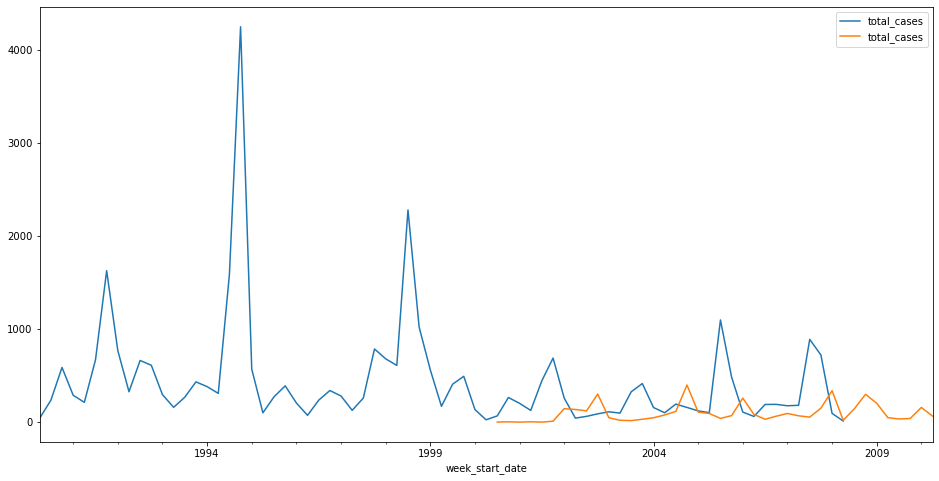

In [4]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))

rows_sj = df_train["city"] == "sj"
rows_iq = df_train["city"] == "iq"

df_train[rows_sj][
    ["week_start_date", "total_cases"]
].set_index(
    pd.DatetimeIndex(df_train[rows_sj]["week_start_date"])
).groupby(pd.Grouper(freq="Q")).sum().plot(ax=ax, label="sj")
df_train[rows_iq][
    ["week_start_date", "total_cases"]
].set_index(
    pd.DatetimeIndex(df_train[rows_iq]["week_start_date"])
).groupby(pd.Grouper(freq="Q")).sum().plot(ax=ax, label="iq")

<AxesSubplot:xlabel='month', ylabel='total_cases'>

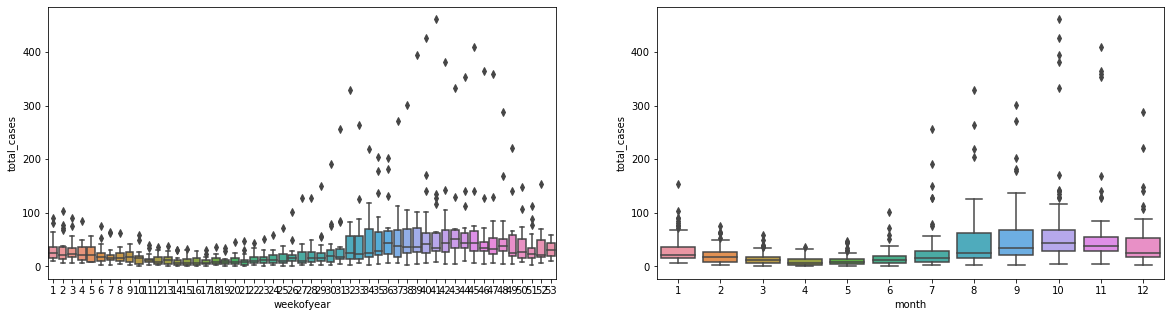

In [5]:
fig, ax = plt.subplots(1, 2, figsize=(20, 5))

sns.boxplot(
    x="weekofyear",
    y="total_cases",
    data=df_train[rows_sj],
    ax=ax[0],
)
sns.boxplot(
    x="month",
    y="total_cases",
    data=df_train[rows_sj],
    ax=ax[1],
)

Presence of strong outlier during periods of outbreak.

In [6]:
weekly_cases_iq = df_train[rows_iq][
    ["weekofyear", "total_cases"]
].groupby("weekofyear").mean()
poly_fit_iq = np.polyfit(
    weekly_cases_iq.index,
    weekly_cases_iq["total_cases"],
    deg=4,
)
poly_line_iq = np.poly1d(poly_fit_iq)

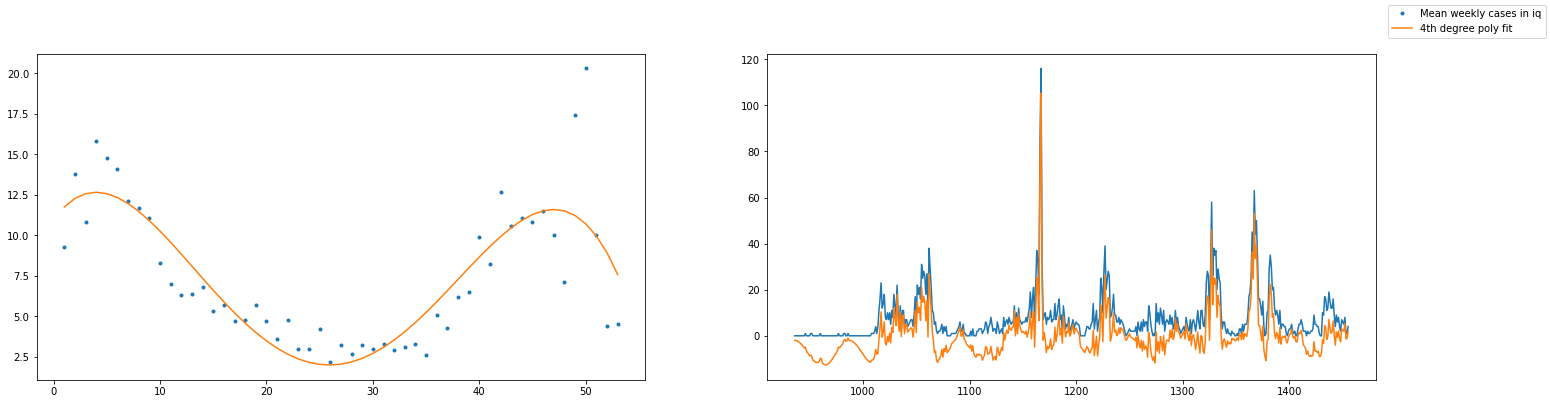

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(24, 6))
ax[0].plot(
    weekly_cases_iq.index,
    weekly_cases_iq["total_cases"],
    marker=".",
    linestyle="None",
    label="Mean weekly cases in iq",
)
ax[0].plot(
    weekly_cases_iq.index,
    poly_line_iq(weekly_cases_iq.index),
    label="4th degree poly fit",
)
ax[1].plot(df_train[rows_iq].index, df_train[rows_iq]["total_cases"])
ax[1].plot(
    df_train[rows_iq].index,
    df_train[rows_iq]["total_cases"] - poly_line_iq(
        df_train[rows_iq]["weekofyear"]
    ),
)
fig.legend()

In [8]:
weekly_cases_sj = df_train[rows_sj][
    ["weekofyear", "total_cases"]
].groupby("weekofyear").mean()
poly_fit_sj = np.polyfit(
    weekly_cases_sj.index,
    weekly_cases_sj["total_cases"],
    deg=4,
)
poly_line_sj = np.poly1d(poly_fit_sj)

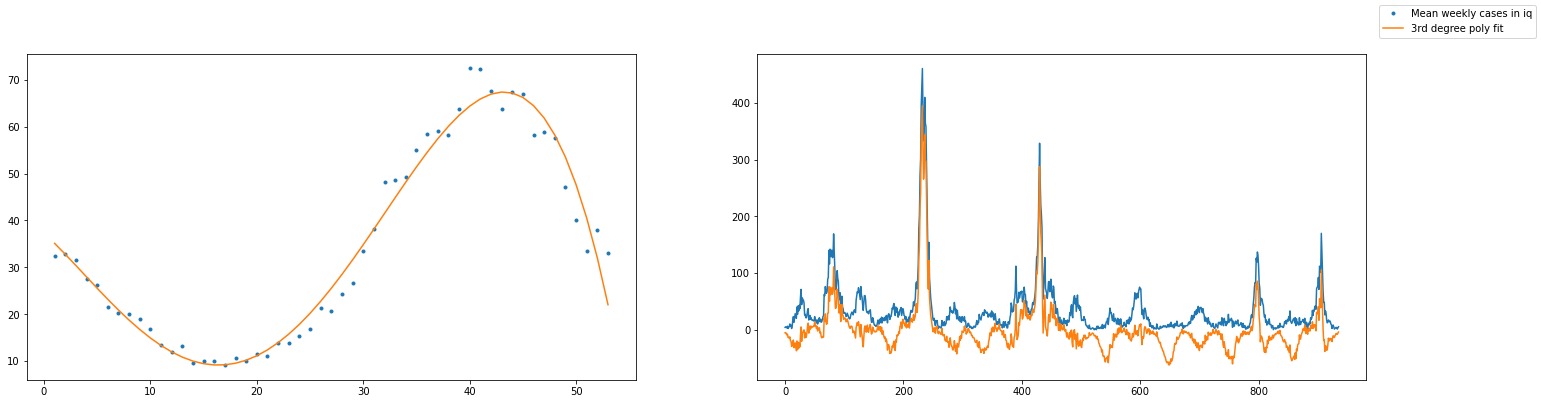

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(24, 6))
ax[0].plot(
    weekly_cases_sj.index,
    weekly_cases_sj["total_cases"],
    marker=".",
    linestyle="None",
    label="Mean weekly cases in iq",
)
ax[0].plot(
    weekly_cases_sj.index,
    poly_line_sj(weekly_cases_sj.index),
    label="3rd degree poly fit",
)
ax[1].plot(df_train[rows_sj].index, df_train[rows_sj]["total_cases"])
ax[1].plot(
    df_train[rows_sj].index,
    df_train[rows_sj]["total_cases"] - poly_line_sj(
        df_train[rows_sj]["weekofyear"]
    ),
)
fig.legend()

In [10]:
poly_data_sj = poly_line_sj(weekly_cases_sj.index)
poly_data_iq = poly_line_iq(weekly_cases_iq.index)
for i in weekly_cases_sj.index:
    df_train.loc[
        rows_sj & (df_train["weekofyear"] == i),
        "poly_fit",
    ] = poly_data_sj[i - 1]
    df_train.loc[
        rows_iq & (df_train["weekofyear"] == i),
        "poly_fit",
    ] = poly_data_iq[i - 1]
    df_test.loc[
        (df_test["city"] == "sj") & (df_test["weekofyear"] == i),
        "poly_fit",
    ] = poly_data_sj[i - 1]
    df_test.loc[
        (df_test["city"] == "iq") & (df_test["weekofyear"] == i),
        "poly_fit",
    ] = poly_data_iq[i - 1]

In [11]:
df_train_sj = df_train[rows_sj]
df_train_iq = df_train[rows_iq].reset_index().drop("index", axis=1)
df_test_sj = df_test[df_test["city"] == "sj"]
df_test_iq = df_test[df_test["city"] == "iq"].reset_index().drop(
    "index",
    axis=1,
)

# Data pipeline

In [12]:
numeric_cols = df_train.select_dtypes(
    include=[np.number]
).drop(["year", "weekofyear", "total_cases"], axis=1).columns.tolist()
numeric_cols

['ndvi_ne',
 'ndvi_nw',
 'ndvi_se',
 'ndvi_sw',
 'precipitation_amt_mm',
 'reanalysis_air_temp_k',
 'reanalysis_avg_temp_k',
 'reanalysis_dew_point_temp_k',
 'reanalysis_max_air_temp_k',
 'reanalysis_min_air_temp_k',
 'reanalysis_precip_amt_kg_per_m2',
 'reanalysis_relative_humidity_percent',
 'reanalysis_sat_precip_amt_mm',
 'reanalysis_specific_humidity_g_per_kg',
 'reanalysis_tdtr_k',
 'station_avg_temp_c',
 'station_diur_temp_rng_c',
 'station_max_temp_c',
 'station_min_temp_c',
 'station_precip_mm',
 'quarter',
 'month',
 'poly_fit']

In [13]:
best_raw_features = [
    "reanalysis_specific_humidity_g_per_kg",
    "reanalysis_dew_point_temp_k",
    "station_avg_temp_c",
    "station_min_temp_c",
    "poly_fit",
]

In [14]:
def datapipeline(
    df_train,
    df_test,
    numeric_cols,
    categorical_cols=None,
):
    df_train.loc[:, numeric_cols].interpolate(inplace=True)
    df_test.loc[:, numeric_cols].interpolate(inplace=True)
    numeric_pipeline = Pipeline(
        [
            ("imputer", SimpleImputer(strategy="mean")),
            ("features",FeatureUnion([
                ("poly", PolynomialFeatures(
                    degree=2,
                    interaction_only=False,
                    include_bias=True,
                ))
            ])),
            ("scaler", RobustScaler()),
        ]
    )
    numeric_pipeline.fit(
        df_train[numeric_cols],
        df_train["total_cases"],
    )

    if categorical_cols is not None:
        encoder = OneHotEncoder()
        encoder.fit(df_train[categorical_cols])

        numeric_train = numeric_pipeline.transform(
            df_train[numeric_pipeline]
        )
        categorical_train = encoder.transform(
            df_train[categorical_cols]
        ).toarray()
        train_features = pd.DataFrame(
            np.concatenate(
                (numeric_train, categorical_train),
                axis=1,
            )
        )
        train_features["total_cases"] = df_train["total_cases"]

        numeric_test = numeric_pipeline.transform(
            df_test[numeric_cols]
        )
        categorical_test = encoder.transform(
            df_test[categorical_cols]
        ).toarray()
        test_features = pd.DataFrame(
            np.concatenate(
                (numeric_test, categorical_test),
                axis=1,
            )
        )
        # Additional columsn for submission format
        test_features["city"] = df_test["city"]
        test_features["year"] = df_test["year"]
        test_features["weekofyear"] = df_test["weekofyear"]
    else:
        numeric_train = numeric_pipeline.transform(
            df_train[numeric_cols]
        )
        train_features = pd.DataFrame(numeric_train)
        train_features["total_cases"] = df_train["total_cases"]

        numeric_test = numeric_pipeline.transform(
            df_test[numeric_cols]
        )
        test_features = pd.DataFrame(numeric_test)
        test_features["city"] = df_test["city"]
        test_features["year"] = df_test["year"]
        test_features["weekofyear"] = df_test["weekofyear"]
    
    return train_features, test_features

In [15]:
numeric_cols = best_raw_features

In [16]:
train_features_iq, test_features_iq = datapipeline(
    df_train_iq,
    df_test_iq,
    numeric_cols,
)
train_features_sj, test_features_sj = datapipeline(
    df_train_sj,
    df_test_sj,
    numeric_cols,
)

In [17]:
features_dir = data_dir / "features"
features_dir.mkdir(parents=True, exist_ok=True)

In [18]:
train_features_sj.to_csv(features_dir / "sj_train.csv", index=False)
train_features_iq.to_csv(features_dir / "iq_train.csv", index=False)
test_features_sj.to_csv(features_dir / "sj_test.csv", index=False)
test_features_iq.to_csv(features_dir / "iq_test.csv", index=False)